# 1. Setup and Get Data


1.1 Install Dependencies and Setup

In [1]:
pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.2.1.tar.gz (1.5 MB)
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached imgviz-1.7.2-py3-none-any.whl (7.7 MB)
  Using cached natsort-8.3.1-py3-none-any.whl (38 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
  Created wheel for labelme: filename=labelme-5.2.1-py3-none-any.whl size=1466735 sha256=17dc2714c8bd32c2963274ec2c7600a8931be3f3a5749eceefcafedc88f7c548
  Stored in directory: c:\users\diwas\appdata\local\pip\cache\wheels\44\d5\94\36afe0ac07148900fd808dbf13b5abcb1361920c2cbde8af60
Successfully built labelme
Note: you may need to restart the kernel to use updated packages.


1.2 Collect images using Opencv

In [2]:
import os
import time
import uuid
import cv2

In [3]:
uuid.uuid1()

UUID('48a34b4a-ff6e-11ed-ba26-9828a6115c11')

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('collecting images {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

collecting images 0
collecting images 1
collecting images 2
collecting images 3
collecting images 4
collecting images 5
collecting images 6
collecting images 7
collecting images 8
collecting images 9
collecting images 10
collecting images 11
collecting images 12
collecting images 13
collecting images 14
collecting images 15
collecting images 16
collecting images 17
collecting images 18
collecting images 19
collecting images 20
collecting images 21
collecting images 22
collecting images 23
collecting images 24
collecting images 25
collecting images 26
collecting images 27
collecting images 28
collecting images 29


1.3 Annotate Images with LabelMe

In [9]:
!labelme

# 2. Review Dataset and Build Image Loading Fucntion

2.1 Import TF and Deps


In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2.2 Limit GPU Memory Growth

In [3]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.test.is_gpu_available()

False

2.3 Load Image into TF Data Pipeline

In [44]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [29]:
images.as_numpy_iterator().next()

b'data\\images\\176e3500-ff71-11ed-830a-9828a6115c11.jpg'

In [20]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [48]:
images = images.map(load_image)

In [49]:
images.as_numpy_iterator().next()

array([[[139, 116, 134],
        [139, 116, 134],
        [139, 116, 134],
        ...,
        [143, 128, 149],
        [145, 131, 154],
        [146, 132, 155]],

       [[139, 116, 134],
        [139, 116, 134],
        [139, 116, 134],
        ...,
        [144, 129, 150],
        [146, 131, 154],
        [146, 132, 155]],

       [[139, 114, 133],
        [140, 115, 134],
        [140, 115, 134],
        ...,
        [145, 130, 153],
        [146, 131, 154],
        [148, 133, 156]],

       ...,

       [[214, 189, 219],
        [214, 191, 220],
        [210, 194, 223],
        ...,
        [140, 100, 127],
        [140, 100, 127],
        [139,  99, 126]],

       [[215, 190, 220],
        [214, 191, 220],
        [210, 194, 223],
        ...,
        [140, 100, 127],
        [139,  99, 125],
        [139,  99, 125]],

       [[216, 191, 221],
        [213, 193, 221],
        [211, 195, 224],
        ...,
        [140, 100, 127],
        [140, 100, 126],
        [139,  99, 125]]

In [33]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

2.3 View Raw Images with Matplotlib

In [6]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### 3. Partition Unaugmented Data

3.1 Manually Split Data into TRAIN, TEST and VAL

3.2 Move the matching labels


In [53]:
90*0.7 # 63 to train

62.99999999999999

In [54]:
90 * .15 #14 and 13 to test and val

13.5

3.2 Move the Matching  Labels

In [55]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

#    4 Applying Image Augmentation on Images and Labels using Albumentatios

4.1 Setup Albumentations Transform Pipeline

In [18]:
import albumentations as alb

In [7]:
img = cv2.imread(os.path.join('data','train','images','1a030b77-ff71-11ed-a5f4-9828a6115c11.jpg'))

In [10]:
img.shape

(480, 640, 3)

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                      bbox_params = alb.BboxParams(format = 'albumentations',
                                                  label_fields = ['class_labels']))

4.2 Load a Test Image and Annotation with OpenCV and JSON

In [8]:
img = cv2.imread(os.path.join('data','train','images','1a030b77-ff71-11ed-a5f4-9828a6115c11.jpg'))

In [9]:
with open(os.path.join('data','train','labels','1a030b77-ff71-11ed-a5f4-9828a6115c11.json'), 'r') as f:
    label = json.load(f)

In [11]:
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[206.76470588235296, 116.47058823529414],
    [450.88235294117646, 391.47058823529414]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\1a030b77-ff71-11ed-a5f4-9828a6115c11.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcY

In [78]:
type(label['shapes'])

list

In [15]:
label['shapes'][0]['points'] #pascal_voc format

[[206.76470588235296, 116.47058823529414],
 [450.88235294117646, 391.47058823529414]]

4.3 Extract Coordinates and Rescale to Match Image Resolution

In [16]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [17]:
coords

[206.76470588235296,
 116.47058823529414,
 450.88235294117646,
 391.47058823529414]

In [18]:
coords = list(np.divide(coords, [640,480,640,480]))

In [19]:
coords #albumanetations format

[0.3230698529411765,
 0.24264705882352947,
 0.7045036764705882,
 0.8155637254901962]

4.4 Apply Augmentations and View Results

In [26]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])

In [27]:
type(augmented)
augmented.keys()
augmented['image'].shape
augmented['bboxes']
augmented

{'image': array([[[215, 140, 142],
         [222, 146, 147],
         [228, 150, 151],
         ...,
         [ 80,  58, 116],
         [ 80,  58, 116],
         [ 80,  58, 117]],
 
        [[215, 138, 141],
         [224, 146, 147],
         [230, 153, 151],
         ...,
         [ 80,  58, 116],
         [ 80,  58, 116],
         [ 79,  57, 115]],
 
        [[215, 139, 140],
         [221, 145, 146],
         [223, 148, 146],
         ...,
         [ 78,  59, 116],
         [ 80,  58, 116],
         [ 77,  58, 115]],
 
        ...,
 
        [[147, 119, 148],
         [147, 119, 148],
         [147, 119, 148],
         ...,
         [144, 121, 149],
         [144, 121, 149],
         [144, 122, 150]],
 
        [[147, 119, 148],
         [147, 119, 148],
         [147, 119, 148],
         ...,
         [145, 123, 148],
         [145, 122, 150],
         [142, 123, 150]],
 
        [[146, 118, 148],
         [146, 118, 148],
         [146, 118, 148],
         ...,
         [145, 123,

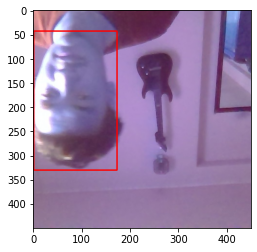

In [28]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
             (255, 0, 0),2)
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

5.1 Run Augmentation Pipeline

In [6]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')): 
        img = cv2.imread(os.path.join('data',partition, 'images', image))
        
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annontation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation, f)
                    
                    
        except Exception as e:
            print(e)
            
                
            
                

                                   

name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'augmentor' is not defined
name 'au

5.2 Load Augmented Images to Tensorflow Dataset

In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x : tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x : x/255)

In [22]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x : tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x : x/255)

In [23]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [61]:
train_images.as_numpy_iterator().next()

array([[[0.5912377 , 0.5481005 , 0.61476713],
        [0.6004902 , 0.5485294 , 0.62218136],
        [0.6044118 , 0.54264706, 0.61715686],
        ...,
        [0.6245098 , 0.54607844, 0.6519608 ],
        [0.6165441 , 0.54558825, 0.6408701 ],
        [0.6098652 , 0.5466299 , 0.6333946 ]],

       [[0.591299  , 0.54246324, 0.6208946 ],
        [0.5971201 , 0.5441176 , 0.62352943],
        [0.6186274 , 0.5514706 , 0.627451  ],
        ...,
        [0.6117647 , 0.53333336, 0.6392157 ],
        [0.6113358 , 0.5329044 , 0.63192403],
        [0.60655636, 0.5356005 , 0.6305147 ]],

       [[0.5862745 , 0.529902  , 0.62009805],
        [0.597549  , 0.5372549 , 0.6269608 ],
        [0.6117647 , 0.5372549 , 0.62352943],
        ...,
        [0.6240196 , 0.53382355, 0.64362746],
        [0.6156863 , 0.5372549 , 0.6362745 ],
        [0.6153799 , 0.544424  , 0.64362746]],

       ...,

       [[0.5071691 , 0.3581495 , 0.4091299 ],
        [0.49258578, 0.35140932, 0.39748776],
        [0.47493872, 0

# 6. Prepare Labels

6.1 Build Label Loading Function

In [24]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

6.2 Load Labels to Tensorflow Dataset

In [5]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)

In [6]:
train_labels.as_numpy_iterator().next()

b'aug_data\\train\\labels\\176e3500-ff71-11ed-830a-9828a6115c11.0.json'

In [25]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x : tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x : tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_labels =val_labels.map(lambda x : tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.09906, 0.1073 , 0.5796 , 0.663  ], dtype=float16))

# 7 Combine Labels and Image Samples


7.1 Check Partition Lengths

In [17]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

7.2 Create Final Datasets (Images/Labels)

In [28]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [29]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [30]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [119]:
val.as_numpy_iterator().next()

(array([[[[0.5074142 , 0.36623776, 0.47604167],
          [0.5058824 , 0.3647059 , 0.4745098 ],
          [0.5074755 , 0.36629903, 0.47610295],
          ...,
          [0.46519607, 0.36715686, 0.48480392],
          [0.4627451 , 0.3647059 , 0.48235294],
          [0.46029413, 0.36715686, 0.48235294]],
 
         [[0.5019608 , 0.36862746, 0.4745098 ],
          [0.5019608 , 0.36862746, 0.4745098 ],
          [0.5063113 , 0.37297794, 0.4788603 ],
          ...,
          [0.4623162 , 0.36427698, 0.48192403],
          [0.4588848 , 0.3608456 , 0.47849265],
          [0.4627451 , 0.3647059 , 0.47990197]],
 
         [[0.50373775, 0.3625613 , 0.4723652 ],
          [0.5063726 , 0.36519608, 0.475     ],
          [0.50980395, 0.36862746, 0.47843137],
          ...,
          [0.45882353, 0.36078432, 0.47843137],
          [0.4622549 , 0.36421567, 0.48186275],
          [0.46452206, 0.3713848 , 0.48658088]],
 
         ...,
 
         [[0.57665443, 0.40704656, 0.5036152 ],
          [0.58468

In [27]:
val.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [126]:
train.as_numpy_iterator().next()

(array([[[[0.33143383, 0.22555147, 0.39417893],
          [0.3295956 , 0.22352941, 0.39117646],
          [0.32873774, 0.22138481, 0.38216913],
          ...,
          [0.66207105, 0.48952207, 0.5797181 ],
          [0.5515931 , 0.37120098, 0.4834559 ],
          [0.3550858 , 0.16341911, 0.30226716]],
 
         [[0.33118874, 0.22530638, 0.39393383],
          [0.33474264, 0.22794117, 0.3947304 ],
          [0.33339462, 0.22310048, 0.38535538],
          ...,
          [0.671201  , 0.49816176, 0.58835787],
          [0.5064951 , 0.32610294, 0.43933824],
          [0.36133578, 0.17849265, 0.31476715]],
 
         [[0.3427696 , 0.23688726, 0.40551472],
          [0.34025735, 0.23045343, 0.39123774],
          [0.32941177, 0.21568628, 0.3882353 ],
          ...,
          [0.6700368 , 0.48094362, 0.5754902 ],
          [0.4865196 , 0.2875    , 0.4154412 ],
          [0.35704657, 0.16887255, 0.31262255]],
 
         ...,
 
         [[0.53333336, 0.43529412, 0.5529412 ],
          [0.53290

7.3 View Images and Annotations

In [31]:
data_samples = train.as_numpy_iterator()

In [32]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


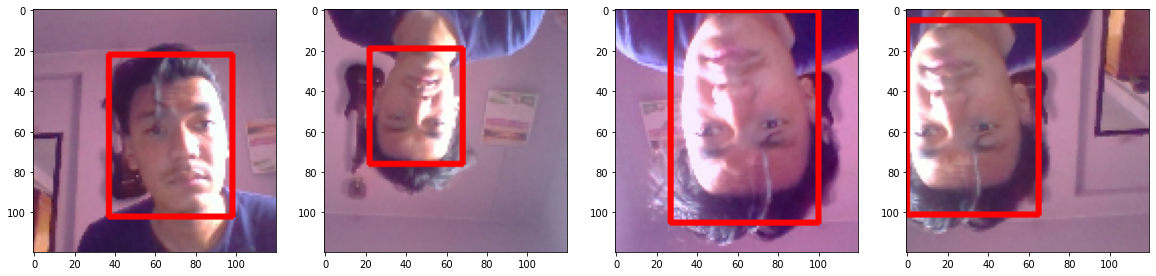

In [33]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255, 0, 0), 2)
    ax[idx].imshow(sample_image)
                    

## 8 Build Deep Learning using the Functional API


#### 8.1 Import Layers and Base Network

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### 8.2 Download VGG16

In [35]:
vgg = VGG16(include_top = False)

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### 8.3 Build instance of Network


Building Neural Network - Focus on the input and getting to the output and then you can tweak what happens in the middle, tweak the hidden layers

In terms of our hidden layers:
vgg = VGG16(include_top = False)(input_layer) -> Here we are creaing a layer and telling the layer what we are passing

Input_layer goes into vgg layer and our vgg layers is going to be put into something else. This is how the NN is stacked

In [37]:
def build_model():
    input_layer = Input(shape=(120,120,3)) #specifying input layer
    
    vgg = VGG16(include_top = False)(input_layer) # include_top =False drops the final layers
    
    # two prediction heads 
    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1) 
    class2 = Dense(1, activation='sigmoid')(class1) # calssfication is mapping to class2
                                                    # it is a dense layer, which has 1 op and activation fucntion is sigmoid which value ranges from 0-1
    #regression model, Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2) 
    regress2 = Dense(4, activation = 'sigmoid')(regress1) #second op is going to be regress2, which has 4 op and activation func is sigmoid ([0.7    , 0.1416 , 1.     , 0.6743 ],)
    
    facetracker = Model(inputs = input_layer, outputs = [class2, regress2]) # outputs = [classification op, regression op]
    return facetracker


#### 8.4 Test out Neural Network

In [57]:
facetracker = build_model()

In [58]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

X will be our images and y will be our labels

In [40]:
X, y = train.as_numpy_iterator().next() #take sample out of our training pipeline

In [41]:
facetracker.predict(X) #predicted values

1/1 [==============================] - 1s 856ms/step


[array([[0.6144882 ],
        [0.6967135 ],
        [0.60547006],
        [0.71197546],
        [0.62800974],
        [0.6624602 ],
        [0.67154014],
        [0.5754189 ]], dtype=float32),
 array([[0.24674588, 0.35998634, 0.5902909 , 0.54524136],
        [0.30683067, 0.4446475 , 0.6582097 , 0.45705023],
        [0.23576   , 0.4158432 , 0.6863606 , 0.50796115],
        [0.2564104 , 0.37944457, 0.62335587, 0.47876018],
        [0.24458696, 0.46551377, 0.62588423, 0.46741295],
        [0.20733093, 0.3781911 , 0.6034869 , 0.5796092 ],
        [0.2746436 , 0.339755  , 0.6730724 , 0.5062336 ],
        [0.2504036 , 0.48064017, 0.64654016, 0.47373816]], dtype=float32)]

we pass x into our facetracker.predict(). This will give us classes and coordinates. Right now we haven't trained it so it will be crap

In [42]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 351ms/step


In [44]:
from sklearn import metrics


In [46]:
classes


array([[0.42612833],
       [0.49489322],
       [0.46070695],
       [0.52482706],
       [0.52417904],
       [0.43769744],
       [0.40403676],
       [0.44137016]], dtype=float32)

In [30]:
X.shape

(8, 120, 120, 3)

In [139]:
(tf.cast(y[1], tf.float32))

<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.09906006, 0.31713867, 0.57958984, 0.8725586 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.14648438, 0.48486328, 0.74121094],
       [0.6855469 , 0.09631348, 1.        , 0.6748047 ],
       [0.37060547, 0.21655273, 0.91308594, 0.8276367 ],
       [0.        , 0.25561523, 0.45825195, 0.84375   ],
       [0.38891602, 0.47924805, 0.6635742 , 0.77978516]], dtype=float32)>

In [157]:
classes.shape

(8, 1)

In [143]:
a, s = val.as_numpy_iterator().next()

In [146]:
a

array([[[[0.6293505 , 0.54748774, 0.6283701 ],
         [0.62420344, 0.5503064 , 0.6284314 ],
         [0.62077206, 0.54626226, 0.62469363],
         ...,
         [0.60490197, 0.5264706 , 0.63235295],
         [0.5992034 , 0.5242034 , 0.6338235 ],
         [0.6039216 , 0.53186274, 0.6367647 ]],

        [[0.6230392 , 0.5367647 , 0.62009805],
         [0.6128064 , 0.53682595, 0.6157476 ],
         [0.61715686, 0.5411765 , 0.62009805],
         ...,
         [0.61219364, 0.5337623 , 0.6396446 ],
         [0.6052696 , 0.533701  , 0.63615197],
         [0.5944853 , 0.5210784 , 0.6302083 ]],

        [[0.61599267, 0.52971816, 0.61991423],
         [0.6240809 , 0.5378064 , 0.6201593 ],
         [0.64705884, 0.5529412 , 0.6392157 ],
         ...,
         [0.61219364, 0.5337623 , 0.6396446 ],
         [0.60490197, 0.53333336, 0.6357843 ],
         [0.6068627 , 0.5433211 , 0.63884807]],

        ...,

        [[0.5093137 , 0.26960784, 0.3122549 ],
         [0.92420346, 0.67224264, 0.6344975 ]

Note: As we have two outputs, we actually need to do a little bit of tweaking, when we go and train because we need a specific loss function for our classification model and another specific one for our Regression model

# 9. Define Losses and Optimizers

#### 9.1 Define Optimizer and LR

First we will specify what our Learning Rate decay is going to be. What we are spcifying here is how we can decrease the learning rate in such a way that we are 75% of the original learning rate after each epoch

Epoch - Number of you give data to the neural network.
If you give more epoch you overfit the data. And underfit if you give less epoch

In [101]:
len(train)
len(val)
val


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [100]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [43]:
bacthes_per_epoch = len(train)
lr_decay = (1./0.75 -1)/bacthes_per_epoch

In the given code snippet, the variable batches_per_epoch is being calculated as the length of the train dataset. It is assumed that train is a collection of batches or mini-batches of training data.

The len(train) function returns the number of batches in the train dataset. Therefore, batches_per_epoch represents the total number of batches present in one epoch. An epoch is a complete iteration over the entire training dataset.

The variable lr_decay is calculated using the formula (1./0.75 - 1) / batches_per_epoch. Here, 1./0.75 is equivalent to dividing 1 by 0.75, which results in 1.33333... (recurring decimal).

The purpose of lr_decay is to calculate the learning rate decay factor. Learning rate decay is a technique used in machine learning to gradually reduce the learning rate during training. A smaller learning rate towards the end of training helps the model to converge more accurately.

In this formula, (1./0.75 - 1) calculates the difference between 1 and 0.75, which is 0.25. Dividing this by batches_per_epoch normalizes the decay factor based on the number of batches in an epoch. This ensures that the decay is proportional to the progress of training, regardless of the dataset size.

By using this calculated lr_decay factor in the training process, the learning rate can be reduced gradually over each epoch to facilitate better model convergence.

setting optimizer

In [44]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

#### 9.2 Create Localization Loss and Classification Loss


delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) ==> we will be getting the distance between our actual coords and predicted coords. 

Then we will be calculating actual height of the box, width.
 h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

Also calulcating predicted height and width of the box.     h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

In [45]:
def localization_loss(y_true, yhat):
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
        
    return delta_coords + delta_size # this will give us l

In [46]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [47]:
y[1].shape


(8, 4)

#### 9.3 Test out Loss Metrics

In [48]:
localization_loss(y[1], coords).shape

TensorShape([])

In [49]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7071618>

In [50]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.183389>

# 10. Train Neural Network

Before we train our NN, we need to create our training pipeline

#### 10.1 Create Custom Model Class

First we will be creating a new class called FaceTracker, in which we are passing Model from above. When ever we are creating the subclassing the model class from Keras, there a couple of things that we need to have --> we need to have an init() method, a complie method, train_step method and a call method

Init Method: Here we compile through our initial params. So, in this case we are passing through our pre-built NN (facetracker or eyetracker)

compile method : Whenever we built a keras NN, we typically, create a network, set self.compile, and to our compile method we pass our loss and our optimizer

Train_step : this is where the magic happens, where we actually train our NN. It is going to take one batch of data and it will train on that batch of data. Then, we unpack it into X and y values.

 with tf.GradientTape() as tape: From here we tell keras to start calculating each of the different fucn which are being applied to this information as we go and do stuff within our model

First: we first make prediction from our model(classes, coords = self.model(X, training = True)). This is taking our facetracker model. We are passing through our X values, which are preprocessed images. Setting training = True. We then get classes and coords, which we pass into respectinve losses

batch_classloss : self.closs which is simply our classification loss. We are then passing classfication value (0 or 1) which is true value. And Classes will have the predicted 1s and 0s.

batch_localizaionloss : we are passing yTrue((tf.cast(y[1], tf.float32))(we are casting it to float) and our predicted coords. 

total_loss = we are now going to add batch_localizaionloss and 50% of batch_classloss. we can tweak the 50%

grad: we will now calculate the gradient. This is very important when we are using a custom training step. So, we calculate the gradients and then we use optimizer to go and apply them

Gradient: we use tape.gradient to go and get each one of the gradeints or calculate our gradeints. Through tape.gradient we pass total_loss. So, we are actually calculating the gradients with respect to our loss function. And then we pass it to self.model.trainable_variables. So, what we get out of this is all of the gradients for each one of those variables with respect to that loss function. And then we go and do gradient descent

Gradient descent : opt.apply_gradient(zip(grad, self.model.trainable_variables))

test_step: when we pass our validation dataset. Similar to train_step. we only calculate losses

In [59]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
    
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
           
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
       
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [60]:
model = FaceTracker(facetracker)

In [61]:
model.compile(opt, classloss, regressloss)

#### 10.2 Train

In [62]:
logdir = 'logs'

In [63]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

model.fit will call this model = FaceTracker(facetracker). Fit is going to trigger our train_step and if we pass validation data it will trigger test_step

To model.fit we will be passing training data, .take(50) will pass smaller amount of data. Where as train will pass everything

we will specify how long we want to train for. So, epochs = 40, which means we are going to train for 40 epochs.

we will then specify our validation_data. we specify callback.

as we sepcified that we are going to save this model to a variable hist. This means that we will be able to get our training history. we can then plot it up in performance

In [100]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1230s 3s/step - total_loss: 6.7719e-04 - class_loss: 2.5495e-07 - regress_loss: 6.7707e-04 - val_total_loss: 8.5192e-04 - val_class_loss: 1.7881e-07 - val_regress_loss: 8.5183e-04
Epoch 2/10
473/473 [==============================] - 1203s 3s/step - total_loss: 5.7368e-04 - class_loss: 2.2353e-07 - regress_loss: 5.7357e-04 - val_total_loss: 0.0052 - val_class_loss: 1.0431e-07 - val_regress_loss: 0.0052
Epoch 3/10
473/473 [==============================] - 1184s 2s/step - total_loss: 5.0581e-04 - class_loss: 1.7991e-07 - regress_loss: 5.0572e-04 - val_total_loss: 0.0087 - val_class_loss: 7.4506e-08 - val_regress_loss: 0.0087
Epoch 4/10
473/473 [==============================] - 1209s 3s/step - total_loss: 5.3611e-04 - class_loss: 1.3842e-07 - regress_loss: 5.3604e-04 - val_total_loss: 0.0206 - val_class_loss: 2.9802e-08 - val_regress_loss: 0.0206
Epoch 5/10
473/473 [==============================] - 1216s 3s/step - total_loss: 5.3310

In [90]:
hist.history

{'total_loss': [0.0010423790663480759,
  0.0011760627385228872,
  0.002325695473700762,
  0.0002711316919885576,
  0.0014266982907429338,
  0.0012512931134551764,
  0.0014278271701186895,
  0.0018883408047258854,
  0.00178439577575773,
  0.0013494151644408703,
  0.0005747098475694656,
  0.0007425292860716581,
  0.000247929769102484,
  0.0007997421780601144,
  0.0006922485772520304,
  0.0005223252810537815,
  0.00017280239262618124,
  0.0008433024631813169,
  0.0004028253606520593,
  0.00031332572689279914],
 'class_loss': [1.0728858796937857e-06,
  1.1891235772054642e-05,
  3.993521204392891e-06,
  9.104736818699166e-06,
  1.1369808817107696e-05,
  8.568256816943176e-06,
  3.3378728403477e-06,
  4.768373287333816e-07,
  4.1723268395799096e-07,
  3.5017919799429365e-06,
  9.238736993211205e-07,
  7.152561920520384e-07,
  0.0,
  6.556513199029723e-07,
  2.53319797138829e-07,
  2.5331982556053845e-07,
  0.0,
  1.4901162970204496e-08,
  1.6391280155403365e-07,
  2.980233091420814e-07],
 'r

#### 10.3 Plot Performance

In [40]:
hist.history

NameError: name 'hist' is not defined

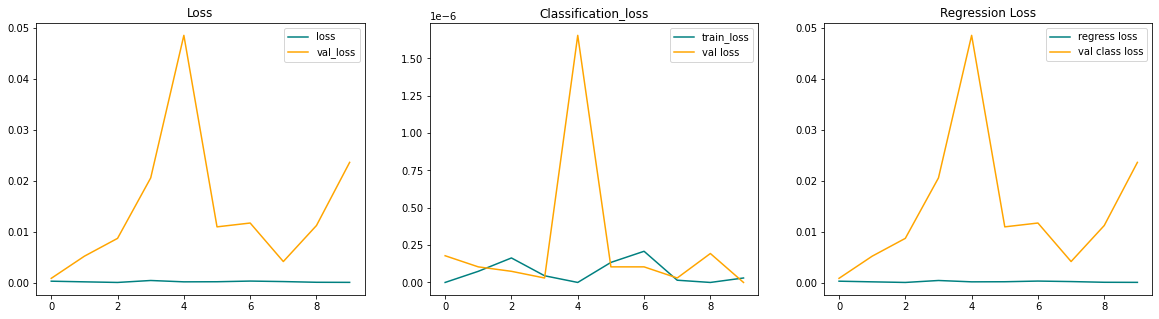

In [101]:
fig, ax = plt.subplots(ncols = 3, figsize =(20,5))

ax[0].plot(hist.history['total_loss'], color = 'teal', label ='loss')
ax[0].plot(hist.history['val_total_loss'], color ='orange', label='val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='train_loss')
ax[1].plot(hist.history['val_class_loss'], color = 'orange', label='val loss')
ax[1].title.set_text('Classification_loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color ='orange', label = 'val class loss')
ax[2].title.set_text("Regression Loss")
ax[2].legend()

plt.show()

# 11. Make Predictions


#### 11.1 Make Predictions on Test Set

In [92]:
test_data = test.as_numpy_iterator()

In [93]:
test_sample = test_data.next()

In [94]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 941ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


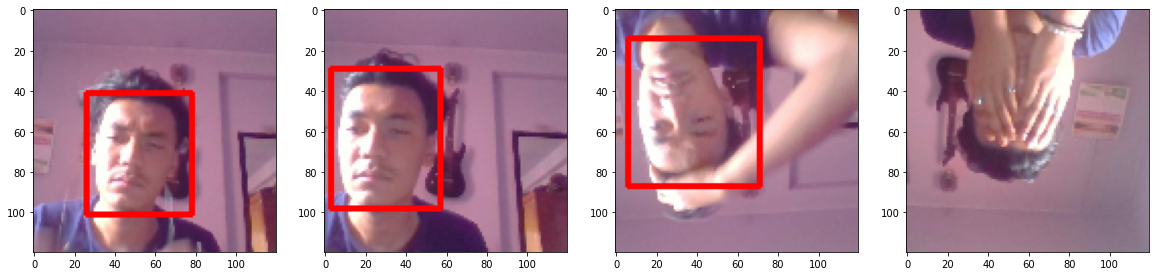

In [95]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)
    
    ax[idx].imshow(sample_image)
        
        

#### 11.2 Save the Model

In [96]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

#### 11.3 Real Time Detection

In [99]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (250,0,0), 2)
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [0, 30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [80,0])),
                      (255,0,0), -1)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 117ms/step
